Enter the ticker symbol:  AAPL


[*********************100%***********************]  1 of 1 completed


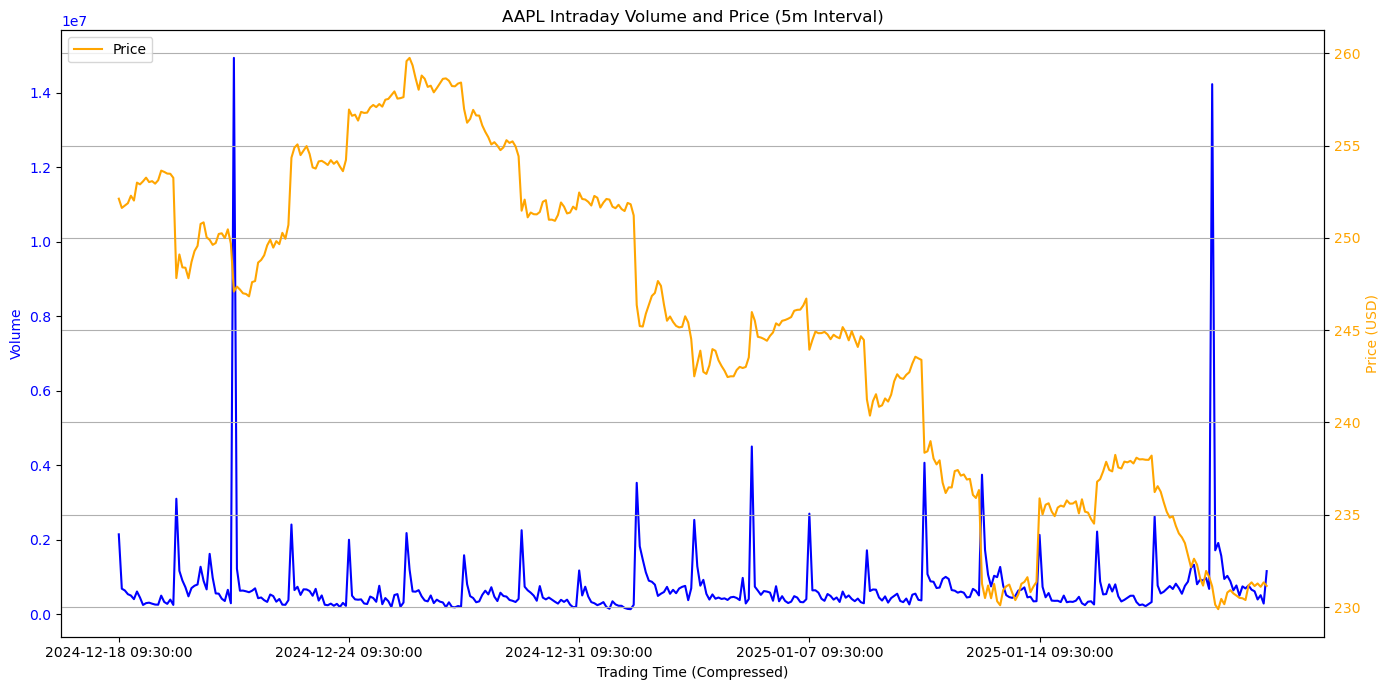

[*********************100%***********************]  1 of 1 completed
C:\Users\Eoin\AppData\Local\Temp\ipykernel_10572\2760714903.py:118: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = pd.merge(data_buy[['Date', 'Close']], data_sell[['Date', 'Close']],


Strat 1 (Buy at 09:45, Sell at 13:30, Rebuy every day):
Price         Date   Close_buy  Close_sell  \
Ticker                    AAPL        AAPL   
0       2024-12-18  251.875000  253.790100   
1       2024-12-19  248.380005  250.669998   
2       2024-12-20  246.996201  252.970001   
3       2024-12-23  254.480804  254.035004   
4       2024-12-26  258.640015  258.630005   
5       2024-12-27  256.929993  255.054993   
6       2024-12-30  251.369995  253.160004   
7       2024-12-31  251.949997  249.679993   
8       2025-01-02  245.880005  242.390793   
9       2025-01-03  242.740005  242.669998   
10      2025-01-06  244.600006  245.000000   
11      2025-01-07  244.835007  242.699997   
12      2025-01-08  241.529999  242.335007   
13      2025-01-10  238.050003  237.425003   
14      2025-01-13  230.479004  233.500000   
15      2025-01-14  235.623993  233.839996   
16      2025-01-15  237.869995  237.429901   
17      2025-01-16  235.679993  228.800095   
18      2025-01-17  230.

In [8]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pytz

ticker = input("Enter the ticker symbol: ").upper()
interval = "5m"
period = "1mo"  

local_timezone = pytz.timezone("US/Eastern")


all_data = yf.download(ticker, interval=interval, period=period)

# Remove duplicates and sort by time
all_data = all_data[~all_data.index.duplicated(keep="first")]
all_data = all_data.sort_index()

if all_data.empty:
    print("No data retrieved. Ensure the ticker is correct and the market is open.")
else:
    # Remove weekend data and non-trading hours
    all_data = all_data[all_data.index.dayofweek < 5]  # Exclude weekends
    trading_hours = (all_data.index.time >= pd.Timestamp("09:30").time()) & \
                    (all_data.index.time <= pd.Timestamp("16:00").time())
    all_data = all_data[trading_hours]

   
    if all_data.index.tz is None:
        all_data.index = all_data.index.tz_localize('GMT')

    
    all_data.index = all_data.index.tz_convert(local_timezone)


    all_data['Trading Time'] = all_data.index.strftime('%Y-%m-%d %H:%M:%S')

    all_data.reset_index(drop=True, inplace=True)

    # Find 16:00 volumes (end of day)
    end_of_day = all_data[all_data['Trading Time'].str.endswith('16:00:00')]

    # Find 09:00 volumes (beginning of next day)
    start_of_day = all_data[all_data['Trading Time'].str.endswith('09:00:00')]

    # Merge the two DataFrames to calculate the volume difference
    volume_data = pd.merge(end_of_day[['Trading Time', 'Volume']],
                           start_of_day[['Trading Time', 'Volume']],
                           left_index=True, right_index=True, suffixes=('_end', '_start'))

    
    volume_data['Volume Difference'] = volume_data['Volume_start'] - volume_data['Volume_end']

    # Plot the volume and price
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot volume
    ax1.plot(all_data['Trading Time'], all_data['Volume'], label="Volume", color="blue")
    ax1.set_ylabel("Volume", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    # Mark the 16:00 volumes on the graph
    ax1.scatter(end_of_day['Trading Time'], end_of_day['Volume'], color="red", label="16:00 Volumes", zorder=5)

    # Mark the 09:00 volumes on the graph
    ax1.scatter(start_of_day['Trading Time'], start_of_day['Volume'], color="green", label="09:00 Volumes", zorder=5)

    # Add secondary y-axis for price
    ax2 = ax1.twinx()
    ax2.plot(all_data['Trading Time'], all_data['Close'], label="Price", color="orange")
    ax2.set_ylabel("Price (USD)", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # Title and labels
    ax1.set_title(f"{ticker} Intraday Volume and Price ({interval} Interval)")
    ax1.set_xlabel("Trading Time (Compressed)")
    fig.tight_layout()

    # Limit x-axis to 10 time stamps by selecting a subset of data points
    time_ticks = all_data['Trading Time'].iloc[::len(all_data)//5]  # Select 10 evenly spaced timestamps
    ax1.set_xticks(time_ticks)  # Set the x-axis ticks
    plt.xticks(rotation=45)

    # Show grid and plot
    plt.grid()
    plt.legend(loc="upper left")
    plt.show()

# Download MRK data for the last month with 5-minute intervals
data = yf.download(ticker, period='1mo', interval='5m')

# Convert the index (timestamps) to Eastern Time
data.index = data.index.tz_convert('UTC').tz_localize(None)  # Remove existing timezone
data.index = data.index.tz_localize('UTC').tz_convert('US/Eastern')  # Convert to Eastern Time

# Define buy and sell times as variables
buytime = '09:45'
selltime = '13:30'

# Filter data to get only the buy and sell times (based on the variables)
data_buy = data.between_time(buytime, f'{buytime[:2]}:{int(buytime[3:]) + 1}')  # Only the buy time row
data_sell = data.between_time(selltime, f'{selltime[:2]}:{int(selltime[3:]) + 1}')  # Only the sell time row

# Use .loc[] to assign the Date column to avoid SettingWithCopyWarning
data_buy = data_buy.copy()  # Create a copy to avoid SettingWithCopyWarning
data_sell = data_sell.copy()  # Create a copy to avoid SettingWithCopyWarning

data_buy['Date'] = data_buy.index.date
data_sell['Date'] = data_sell.index.date

# Merge buy and sell data on the 'Date' column
merged_data = pd.merge(data_buy[['Date', 'Close']], data_sell[['Date', 'Close']], 
                       on='Date', how='inner', suffixes=('_buy', '_sell'))

# Initialize the portfolio with 1000 USD for both strategies
portfolio_value_strat1 = 1000
portfolio_value_strat2 = 1000

# Initialize lists to store portfolio values for each strategy
portfolio_values_strat1 = []  # To store portfolio values each day for Strat 1

# STRAT 1: Loop through the merged data for Strat 1 to calculate portfolio value each day
for _, row in merged_data.iterrows():
    close_buy = row['Close_buy']
    close_sell = row['Close_sell']

    # Calculate how many shares we can buy at buytime with the portfolio amount
    shares_bought = portfolio_value_strat1 / close_buy
    
    # Sell the shares at selltime and get the revenue
    portfolio_value_strat1 = shares_bought * close_sell

    # Store the portfolio value for Strat 1
    portfolio_values_strat1.append(portfolio_value_strat1)

# STRAT 2: For Strat 2, buy on the first day and sell on the last day (selltime of the last day)
# Buy once at buytime on the first day
first_day_close_buy = merged_data.iloc[0]['Close_buy']
shares_bought_strat2 = portfolio_value_strat2 / first_day_close_buy

# Sell once at selltime on the last day
last_day_close_sell = merged_data.iloc[-1]['Close_sell']
final_portfolio_value_strat2 = shares_bought_strat2 * last_day_close_sell

# Add the portfolio values for Strat 1 to the merged data
merged_data['Portfolio_Value_Strategy1'] = portfolio_values_strat1

# Print the results
print(f"Strat 1 (Buy at {buytime}, Sell at {selltime}, Rebuy every day):")
print(merged_data[['Date', 'Close_buy', 'Close_sell', 'Portfolio_Value_Strategy1']])

print(f"\nStrat 2 (Buy at {buytime} on the first day, Sell at {selltime} on the last day):")
print(f"Final Portfolio Value for Strat 2: ${final_portfolio_value_strat2}")
